# 2-Level 6-Factor Full Factorial (With 30 replicates)
# (TESTCASE A)
# Analizing Data

<br />

### Table of Contents
* [Preliminaries](#Preliminaries)
 * Importing Python Package
 * [Reading DOE data and encoded values](#ReadingDOE)
* [DOE Analysis](#DOEAnalysis)
 * [Defining variables and variable labels](#DOEVariables)
 * [Computing Main and Interaction Effects](#DOEEffects)
  * [Constant Effect](#DOEConstantEffect)
  * [Interaction effects (2-variable to 6-variable interactions)](#DOEInteractionEffect)
 * [Analysis of results](#DOE_An)
  * [Analyzing Effects](#DOE_An_eff)
  * [Main effects plot](#DOE_An_MEffPl)
  * [Interaction effects plot](#DOE_An_IEffPl)
  * [Quantile-Quantile Effects Plot](#DOE_An_QEffPl)

### TODO
* Analysis of results:
 * [Utilizing Degrees of Freedom](#dof)
 * [Ordinary Least Squares Regression Model](#ols)
 * [Goodness of Fit](#goodness_of_fit)
 * [Distribution of Error](#distribution_of_error)
 * [Aggregating Results](#aggregating)
 * [Distribution of Variance](#dist_variance)
 * [Residual vs. Response Plots](#residual)

<br />

# Preliminaries <a name="Preliminaries"></a>
## Importing packages

In [2]:
import numpy as np
import pandas as pd
import itertools as it

import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

from thesis_EAfunc import *
from thesis_visfunc import *

In [3]:
import datetime
time_a = datetime.datetime.now()
print(time_a)

2019-05-24 11:08:17.961762


## Reading DOE data and encoded values  <a name="ReadingDOE"></a>

In [4]:
doe = pd.read_pickle('./EA_A_05_data.gz', compression='gzip')
coded_values = pd.read_pickle('./EA_A_05_code.gz', compression='gzip')
coded_values

,Label,Variable type,Value_low,Value_high,encoded_low,encoded_high
index,,,,,,
pop_s,Population size,Numerical,10,30,-1,1
b,Progeny-to-population ratio,Numerical,0.5,5,-1,1
mut_p,Mutation Probability,Numerical (<1),0.1,0.9,-1,1
mut_s,Mutation size,Numerical,0.1,10,-1,1
p_sel,Parent selection,Categorical,fitness proportional,tournament k3,-1,1
s_sel,Survivor selection method,Categorical,fitness proportional,tournament k3,-1,1


In [5]:
doe.head()

,pop_s,b,mut_p,mut_s,p_sel,s_sel,f_min,f_max,f_mean,f_std
run,,,,,,,,,,
0,-1,-1.0,-1.0,-1.0,-1,-1,1.521120,1.527672,1.526376,0.002277
1,-1,-1.0,-1.0,-1.0,-1,-1,0.152513,0.152513,0.152513,0.000000
2,-1,-1.0,-1.0,-1.0,-1,-1,1.047303,1.047303,1.047303,0.000000
3,-1,-1.0,-1.0,-1.0,-1,-1,1.026729,1.031762,1.031259,0.001591
4,-1,-1.0,-1.0,-1.0,-1,-1,0.951708,1.007183,0.970642,0.019984


In [6]:
list(doe.columns[0:6])

['pop_s', 'b', 'mut_p', 'mut_s', 'p_sel', 's_sel']

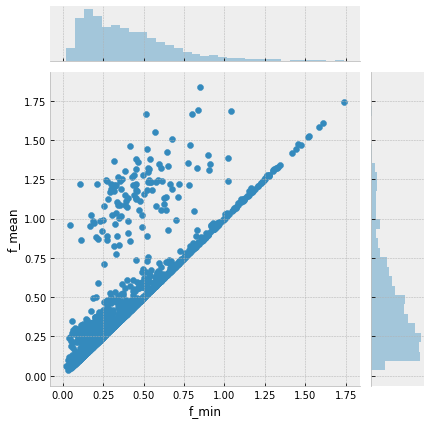

In [7]:
sns.jointplot(x="f_min", y="f_mean", data=doe)

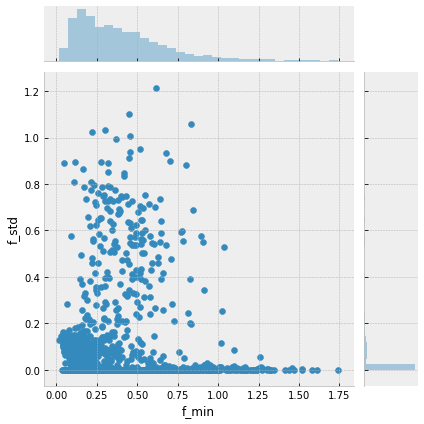

In [8]:
sns.jointplot(x="f_min", y="f_std", data=doe)

# DOE Analisis of Data  <a name="DOEAnalysis"></a>
## Defining variables and variable labels  <a name="DOEVariables"></a>

In [9]:
labels = {}
labels[1] = list(doe.columns[0:6])
for i in [2,3,4,5,6]:
    labels[i] = list(it.combinations(labels[1], i))

obs_list = list(doe.columns[-4:-1])

for k in labels.keys():
    print(str(k) + " : " + str(labels[k]))
print()
print(obs_list)

1 : ['pop_s', 'b', 'mut_p', 'mut_s', 'p_sel', 's_sel']
2 : [('pop_s', 'b'), ('pop_s', 'mut_p'), ('pop_s', 'mut_s'), ('pop_s', 'p_sel'), ('pop_s', 's_sel'), ('b', 'mut_p'), ('b', 'mut_s'), ('b', 'p_sel'), ('b', 's_sel'), ('mut_p', 'mut_s'), ('mut_p', 'p_sel'), ('mut_p', 's_sel'), ('mut_s', 'p_sel'), ('mut_s', 's_sel'), ('p_sel', 's_sel')]
3 : [('pop_s', 'b', 'mut_p'), ('pop_s', 'b', 'mut_s'), ('pop_s', 'b', 'p_sel'), ('pop_s', 'b', 's_sel'), ('pop_s', 'mut_p', 'mut_s'), ('pop_s', 'mut_p', 'p_sel'), ('pop_s', 'mut_p', 's_sel'), ('pop_s', 'mut_s', 'p_sel'), ('pop_s', 'mut_s', 's_sel'), ('pop_s', 'p_sel', 's_sel'), ('b', 'mut_p', 'mut_s'), ('b', 'mut_p', 'p_sel'), ('b', 'mut_p', 's_sel'), ('b', 'mut_s', 'p_sel'), ('b', 'mut_s', 's_sel'), ('b', 'p_sel', 's_sel'), ('mut_p', 'mut_s', 'p_sel'), ('mut_p', 'mut_s', 's_sel'), ('mut_p', 'p_sel', 's_sel'), ('mut_s', 'p_sel', 's_sel')]
4 : [('pop_s', 'b', 'mut_p', 'mut_s'), ('pop_s', 'b', 'mut_p', 'p_sel'), ('pop_s', 'b', 'mut_p', 's_sel'), ('pop_s'

## Computing Main and Interaction Effects <a name="DOEEffects"></a>
### Constant Effect <a name="DOEConstantEffect"></a>

In [10]:
effects = {}

# Start with the constant effect: this is $\overline{y}$
effects[0] = {'x0' : [doe['f_min'].mean(), doe['f_max'].mean(), doe['f_mean'].mean()]}
print(effects[0])

{'x0': [0.396032883441938, 0.6637013443380954, 0.45862888305816335]}


### Main effect of each variable <a name="DOEMainEffect"></a>

In [11]:
effects[1] = {}
for key in labels[1]:
    effects_result = []
    for obs in obs_list:
        effects_df = doe.groupby(key)[obs].mean()
        result = sum([ zz*effects_df.loc[zz] for zz in effects_df.index ])
        effects_result.append(result)
    effects[1][key] = effects_result

effects[1]

{'pop_s': [-0.19476368145641887, -0.048831069924294424, -0.1836620548517996],
 'b': [-0.15888041309413647, 0.13118341337661, -0.05671874500131707],
 'mut_p': [-0.15726570785651744, 0.3485318318399057, -0.03789080268303868],
 'mut_s': [0.1826745236282568, 0.49903849339590994, 0.2548994456810263],
 'p_sel': [-0.019661878500547403, -0.03519995288317834, -0.022930389651859284],
 's_sel': [0.052780218138965995, 0.32837456114640773, 0.15619599391338274]}

### Interaction effects (2-variable to 6-variable interactions) <a name="DOEInteractionEffect"></a>

In [12]:
for c in [2,3,4,5,6]:
    effects[c] = {}
    for key in labels[c]:
        effects_result = []
        for obs in obs_list:
            effects_df = doe.groupby(key)[obs].mean()
            result = sum([ np.prod(zz)*effects_df.loc[zz]/(2**(len(zz)-1)) for zz in effects_df.index ])
            effects_result.append(result)
        effects[c][key] = effects_result

C:\Anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  


In [13]:
def printd(d):
    for k in d.keys():
        print("%25s : %s"%(k,d[k]))

for i in range(1,7):
    printd(effects[i])

                    pop_s : [-0.19476368145641887, -0.048831069924294424, -0.1836620548517996]
                        b : [-0.15888041309413647, 0.13118341337661, -0.05671874500131707]
                    mut_p : [-0.15726570785651744, 0.3485318318399057, -0.03789080268303868]
                    mut_s : [0.1826745236282568, 0.49903849339590994, 0.2548994456810263]
                    p_sel : [-0.019661878500547403, -0.03519995288317834, -0.022930389651859284]
                    s_sel : [0.052780218138965995, 0.32837456114640773, 0.15619599391338274]
           ('pop_s', 'b') : [0.07330750826841534, 0.1349246769950494, 0.08506775788297191]
       ('pop_s', 'mut_p') : [0.05555166927317441, 0.18653679183958566, 0.06755062423419997]
       ('pop_s', 'mut_s') : [0.04444197674671613, 0.13784198082686905, 0.053338895221852256]
       ('pop_s', 'p_sel') : [0.01718584380166968, 0.03546425662783603, 0.02175621360980723]
       ('pop_s', 's_sel') : [-0.012567962972293067, 0.017873820608720836,

## Analysis of results <a name="DOE_An"></a>
### Analyzing Effects <a name="DOE_An_eff"></a>

In [14]:
print(len(effects))

7


In [15]:
master_dict = {}
for nvars in effects.keys():

    effect = effects[nvars]
    for k in effect.keys():
        v = effect[k]
        master_dict[k] = v

master_df = pd.DataFrame(master_dict).T
master_df.columns = obs_list
master_df.head()

,f_min,f_max,f_mean
x0,0.396033,0.663701,0.458629
pop_s,-0.194764,-0.048831,-0.183662
b,-0.158880,0.131183,-0.056719
mut_p,-0.157266,0.348532,-0.037891
mut_s,0.182675,0.499038,0.254899


In [16]:
n=30
k= 6

y1 = master_df[['f_min']].copy()
y1 = y1.iloc[y1['f_min'].abs().argsort].iloc[::-1]
y1 = y1.drop('x0')
y1.columns = ['Effects_Estimate']
y1.index.names = ['Factors']
y1['Sum_of_Squares'] = y1['Effects_Estimate']**2 * n * (2**(k-2))

SS_tot = (doe['f_min']**2).sum() - ((doe['f_min'].sum()**2)/len(doe['f_min']))
SS_err = SS_tot - (y1['Sum_of_Squares'].sum())
y1['%_Contribution'] = y1['Sum_of_Squares']/SS_tot*100

print("Top 10 effects for observable 'minimum fitness:'")
print(y1[:10])
print()
print("Error: " + str(SS_err) + "     " + "Error (% Contribution): " + str(SS_err/SS_tot))

Top 10 effects for observable 'minimum fitness:'
                       Effects_Estimate  Sum_of_Squares  %_Contribution
Factors                                                                
pop_s                         -0.194764       18.207788       13.060579
mut_s                          0.182675       16.017591       11.489535
b                             -0.158880       12.116633        8.691349
mut_p                         -0.157266       11.871601        8.515586
(pop_s, b)                     0.073308        2.579516        1.850305
(b, mut_p)                     0.064599        2.003048        1.436801
(pop_s, mut_p)                 0.055552        1.481274        1.062529
s_sel                          0.052780        1.337161        0.959155
(b, s_sel)                     0.046488        1.037327        0.744083
(pop_s, mut_p, mut_s)         -0.044936        0.969243        0.695245

Error: 64.04140964680002     Error (% Contribution): 0.45937369654037985


In [17]:
ANOVA_y1 = y1.copy()
ANOVA_y1 = ANOVA_y1.drop('Effects_Estimate',axis=1)
ANOVA_y1['Dgrs. Freedom'] = 1
df_tot = len(doe['f_min'])-1
df_err = df_tot - len(master_df)

ANOVA_y1['Mean Sqrs'] = ANOVA_y1['Sum_of_Squares']/1
ms_err = SS_err / df_err

ANOVA_y1['F ratio'] = ANOVA_y1['Mean Sqrs']/ms_err
sig_level=0.05
ANOVA_y1['F critical'] = stats.f.ppf(q=1-sig_level, dfn=1, dfd=df_tot)
ANOVA_y1['Significant'] = (ANOVA_y1['F ratio'] > ANOVA_y1['F critical'])

#ANOVA_y1.loc['Error'] = [SS_err] +[] + []
#ANOVA_y1.loc['Total'] = [SS_tot] + [] + []

df_show = ANOVA_y1.iloc[np.r_[0:10,-2:0]]
df_show

,Sum_of_Squares,%_Contribution,Dgrs. Freedom,Mean Sqrs,F ratio,F critical,Significant
Factors,,,,,,,
pop_s,18.207788,13.060579,1,18.207788,527.400113,3.846309,True
mut_s,16.017591,11.489535,1,16.017591,463.959675,3.846309,True
b,12.116633,8.691349,1,12.116633,350.965954,3.846309,True
mut_p,11.871601,8.515586,1,11.871601,343.868454,3.846309,True
"(pop_s, b)",2.579516,1.850305,1,2.579516,74.717303,3.846309,True
"(b, mut_p)",2.003048,1.436801,1,2.003048,58.019565,3.846309,True
"(pop_s, mut_p)",1.481274,1.062529,1,1.481274,42.906046,3.846309,True
s_sel,1.337161,0.959155,1,1.337161,38.731706,3.846309,True
"(b, s_sel)",1.037327,0.744083,1,1.037327,30.046846,3.846309,True


### Main effects plot <a name="DOE_An_MEffPl"></a>

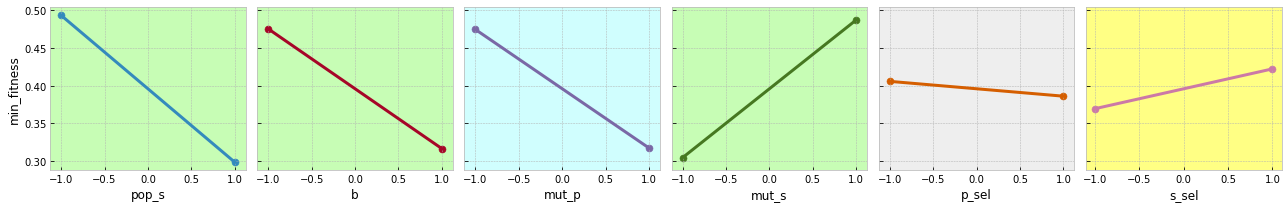

In [18]:
variable = ['pop_s', 'b', 'mut_p', 'mut_s', 'p_sel', 's_sel']
f, axs = plt.subplots(1, 6, figsize=(18,3), sharey=True)
x_ci=None
for i in range(len(variable)):
        sns.regplot(x=variable[i], y='f_min', data=doe, x_estimator=np.mean, x_ci=x_ci, ci=None, truncate=True, ax=axs[i])
for ax in axs.flat:
    ax.set_ylabel(None)
axs[0].set_ylabel('min_fitness')

axs[0].set_facecolor('xkcd:pale green')
axs[1].set_facecolor('xkcd:pale green')
axs[3].set_facecolor('xkcd:pale green')

axs[2].set_facecolor('xkcd:pale blue')

axs[5].set_facecolor('xkcd:pale yellow')

plt.tight_layout()

### Interaction effects plot <a name="DOE_An_IEffPl"></a>

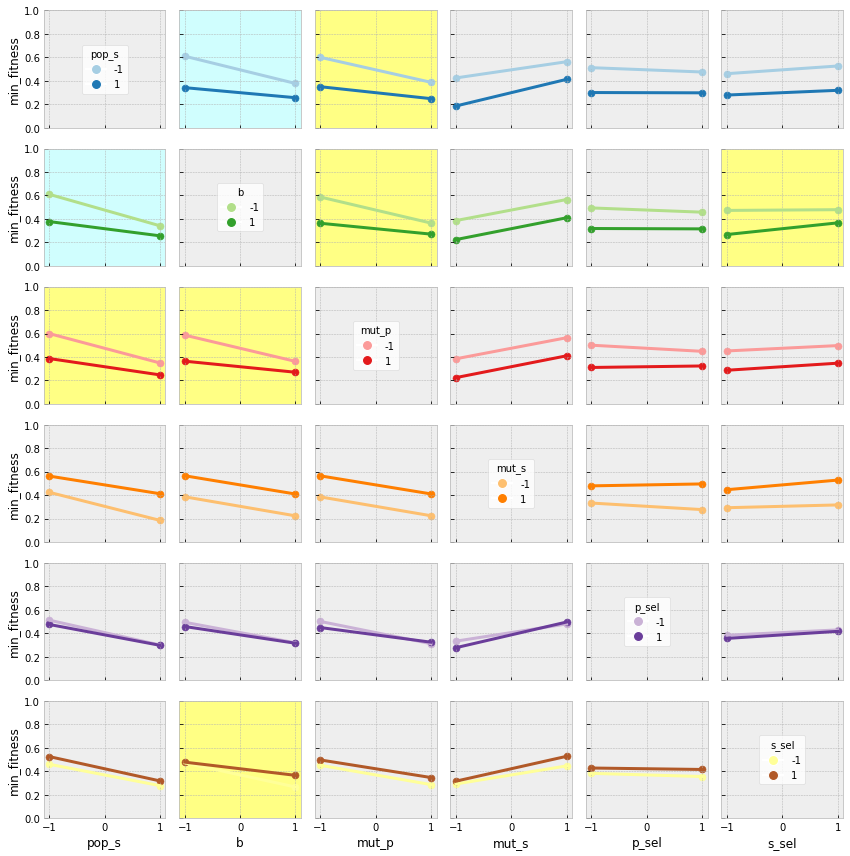

In [19]:
factors = ['pop_s', 'b', 'mut_p', 'mut_s', 'p_sel', 's_sel']
f, axs = plt.subplots(6, 6, figsize=(12, 12), sharey=True, sharex=True)
x_ci = None

# set palette 
palette = it.cycle(sns.color_palette("Paired"))

for i in range(len(factors)):
    for j in range(len(factors)):
        yy = factors[j]
        
        c = next(palette)
        sns.regplot(x=factors[i], y='f_min', data=doe[doe[yy]==-1], label='-1', x_estimator=np.mean, color=c, x_ci=x_ci, ci=None, truncate=True, ax=axs[j,i])
        c = next(palette)
        sns.regplot(x=factors[i], y='f_min', data=doe[doe[yy]==1], label='1', x_estimator=np.mean, color=c, x_ci=x_ci, ci=None, truncate=True, ax=axs[j,i])
        
        #axs[j,i].legend(title=yy,facecolor='white')

        if i==j:
            axs[j,i].clear()

for ax in axs.flat:
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    
axs[0,0].set_xlim((-1.1, 1.1))

from matplotlib.lines import Line2D

for i in range(len(factors)):
    axs[i,0].set_ylabel('min_fitness')
    axs[-1,i].set_xlabel(factors[i])
    legend_elements = [ Line2D([0], [0], marker='o', color='w', label=-1, markerfacecolor=next(palette), markersize=10),
                       Line2D([0], [0], marker='o', color='w', label=1, markerfacecolor=next(palette), markersize=10)]
    axs[i,i].legend(handles=legend_elements, loc='center', title=factors[i], facecolor='white')

axs[0,1].set_facecolor('xkcd:pale blue')
axs[1,0].set_facecolor('xkcd:pale blue')

axs[1,2].set_facecolor('xkcd:pale yellow')
axs[2,1].set_facecolor('xkcd:pale yellow')
axs[0,2].set_facecolor('xkcd:pale yellow')
axs[2,0].set_facecolor('xkcd:pale yellow')
axs[1,5].set_facecolor('xkcd:pale yellow')
axs[5,1].set_facecolor('xkcd:pale yellow')

plt.tight_layout()
plt.show()

### Quantile-Quantile Effects Plot <a name="DOE_An_QEffPl"></a>

Text(0.5, 1.0, 'y1')

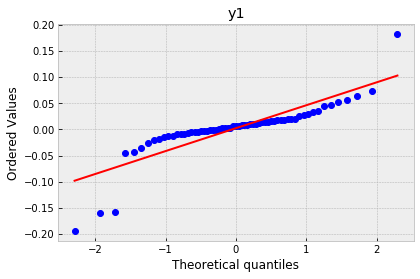

In [20]:
# Quantify which effects are not normally distributed, 
# to assist in identifying important variables

fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(121)

stats.probplot(y1['Effects_Estimate'], dist="norm", plot=ax1)
ax1.set_title('y1')

In [21]:
time_c = datetime.datetime.now()
print(time_c)
print(time_c-time_a)

2019-05-24 11:08:42.070549
0:00:24.108787
